It can be useful to use non-parametric kernel methods to learn a non-linear relationship between the input and the target variables; especially, if the dataset is not linear.

Consider a dataset $(X, y)$.

1. **The standard linear regression** model outputs a linear model which might underfit the data. It is used as follows:

    We optimize for a global $w$ parameter as:
    $$w = (X^T X)^{-1} X^T y$$

    Then, we make the following prediction for a test point $x_i$: 
    $$\hat{y}_i = x_i^T \cdot w$$
    
2. **Locally weighted linear regression** trains a different linear model for each test datapoint $x_i$ based on its proximity to the training points. Therefore, for each $x_i$ we have a corresponding weight vector:
$$w_i = (X^T Z_i X)^{-1} X^T Z_i y$$

    Where $Z_i$ as a diagonal matrix where the diagonal entries correspond to the similarities between the test point and each point in the training set. $Z_i$ can be computed using a kernel function such as the radial basis function (RBF).

    For a test point $x_i$, a prediction is made as follows:
$$\hat{y}_i = x_i \cdot w_i$$




   3- **Nadaraya Watson** is a kernel regression model that weighs the prediction of a test point $x_i$ based on its similarity to the nearby points. The target value for a test point $i$ is computed this way:

$$\hat{y}_i = \frac{\sum_{j=1}^n K(x_i, X_j)y_i}{ \sum_{j=1}^n K(x_i, X_j)}$$
where $n$ is the number of samples in the dataset, and $K(x_i, X_j)$ is the similarity between the test point $x_i$ and train point $X_j$, which is computed using a kernel function such as the radial basis function.

This notebook contains their implementations and several experiments on a synthetic dataset.

## The dataset

We first generate a dataset with features obtained from the normal distribution with noisy sine target values.

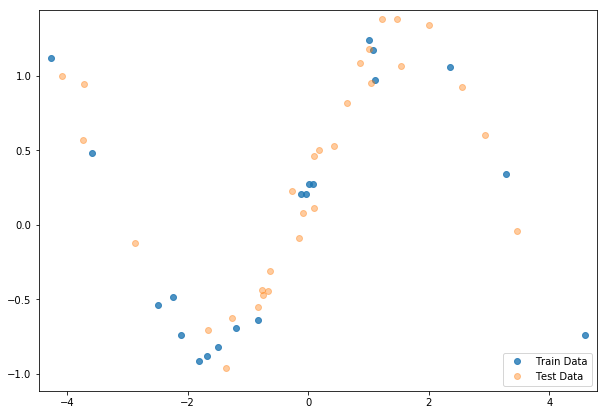

In [84]:
%matplotlib inline

import numpy as np
import pylab as plt
plt.rcParams["figure.figsize"] = (10, 7)

from sklearn.metrics.pairwise import pairwise_kernels

np.random.seed(2)

## 1. Construct training data
n, d = 20, 1
Xtrain = np.sort(np.random.randn(n, 1)*2, axis=0)
ytrain = np.sin(Xtrain) + np.random.rand(n, 1) * 0.5

## 1. Construct test data
n, d = 30, 1
Xtest = np.sort(np.random.randn(n, 1)*2, axis=0)
ytest = np.sin(Xtest) + np.random.rand(n, 1) * 0.5

# 3. Plot Dataset
xmin, xmax = np.min(Xtrain)-.2, np.max(Xtrain)+.2
ymin, ymax = np.min(ytrain)-.2, np.max(ytrain)+.2
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.plot(Xtrain, ytrain, 'o', alpha=0.8, label="Train Data")
plt.plot(Xtest, ytest, 'o', alpha=0.4, label="Test Data")
plt.legend(loc="lower right")
plt.show()



## Linear Regression

Let's first plot the decision boundary made by fitting the standard linear regression model on the training data.

In [79]:
def Fit_LinearRegression(X, y):
    W = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
    return {"W":W}

def Predict_LinearRegression(model, X):
    yhat = X.dot(model["W"])
    return yhat

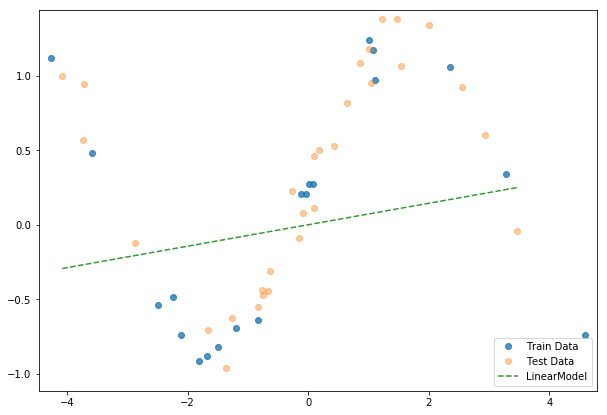

In [80]:
# 1. Train linear regression model
model = Fit_LinearRegression(Xtrain, ytrain)
yhat = Predict_LinearRegression(model, Xtest)

## 2. Plot results
plt.plot(Xtrain, ytrain, 'o', alpha=0.8, label="Train Data")
plt.plot(Xtest, ytest, 'o', alpha=0.4, label="Test Data")
plt.plot(Xtest, yhat, "g--", alpha=0.8, label="LinearModel")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.legend(loc="lower right")
plt.show()

## Locally Weighted Regression

Next, let's plot the locally weighted linear regression model for different test points

In [81]:
def Fit_LocallyWeightedRegression(X, y, gamma=0.3):
    return {"X":X, "y":y, "gamma":gamma}

def Predict_LocallyWeightedRegression(model, X):
    n_points = X.shape[0]
    
    yhat = np.zeros(n_points)
    for i in range(X.shape[0]):
        xtest = X[[i]]
        W = Fit_WeightedRegression(xtest, model["X"], model["y"], 
                                   gamma=model["gamma"])
        yhat[i] = xtest.dot(W)
        
    return yhat

def Line_LocallyWeightedRegression(model, xtest):
    # Predict the linear model for one test point
    W = Fit_WeightedRegression(xtest, model["X"], model["y"], 
                               gamma=model["gamma"])
    
    xplot = np.array([[np.min(model["X"])],[np.max(model["X"])]])
    yplot = xplot.dot(W)
    
    return xplot, yplot

# Fit globally weighted regression
def Fit_WeightedRegression(xtest, X, y, kernel="rbf", gamma=10):
    Z = np.diag(pairwise_kernels(xtest, X, metric=kernel, gamma=gamma).ravel())
    
    W = np.linalg.inv(X.T.dot(Z).dot(X)).dot(X.T.dot(Z).dot(y))

    return W

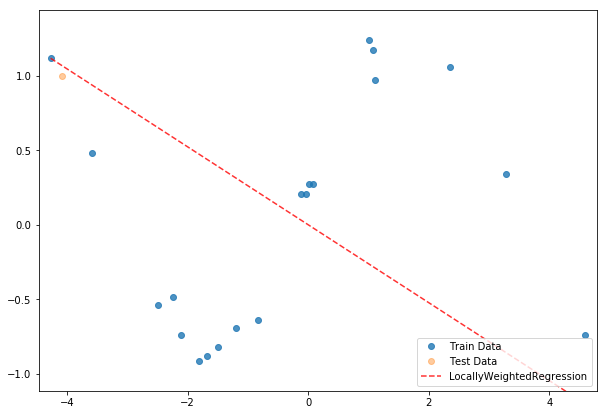

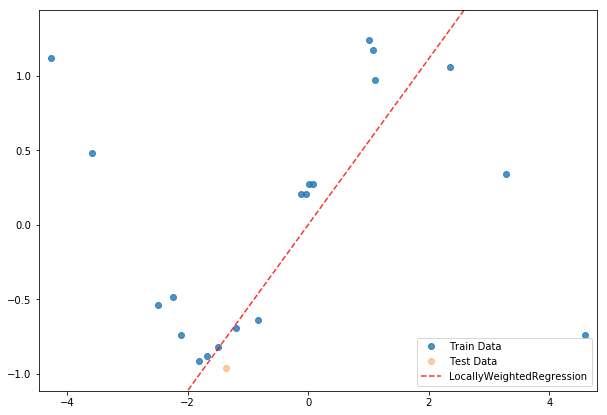

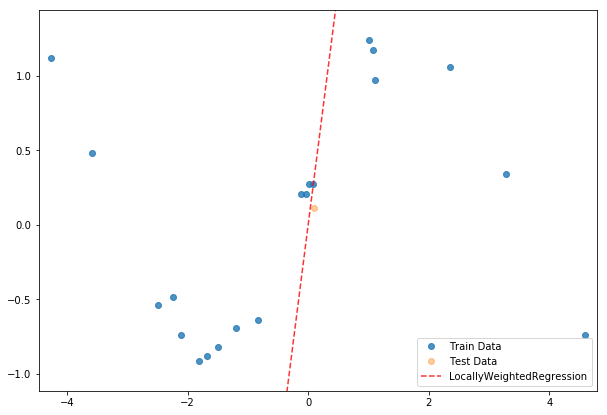

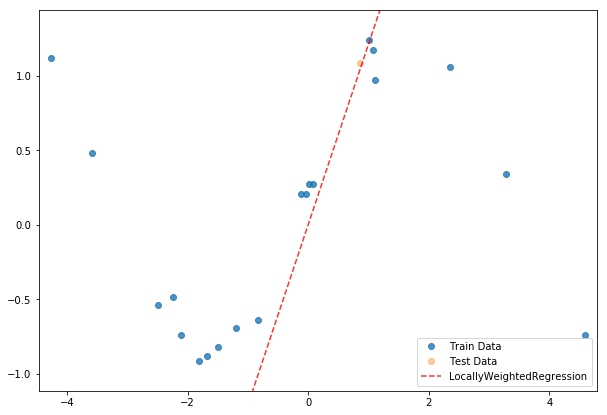

In [82]:
## 3. Train and predict using Locally Weighted Regression
for point in [0, 5, 15, 20]:
    x, y = Xtest[[point]], ytest[[point]]
    model = Fit_LocallyWeightedRegression(Xtrain, ytrain, gamma=100.)
    xplot, yplot = Line_LocallyWeightedRegression(model, x)
    
    ## 5. Plot results
    plt.plot(Xtrain, ytrain, 'o', alpha=0.8, label="Train Data")
    plt.plot(x, y, 'o', alpha=0.4, label="Test Data")
    plt.plot(xplot, yplot,"r--", alpha=0.8, label="LocallyWeightedRegression")

    plt.legend(loc="lower right")
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.show()


For the whole test set, locally weighted linear regression gives the following non-linear decision boundary:

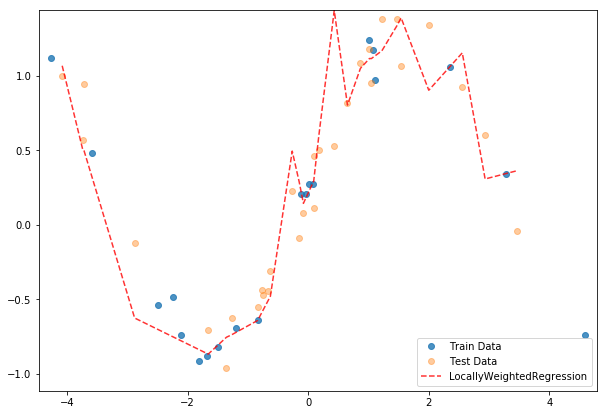

In [83]:
# 1. Fit model
model = Fit_LocallyWeightedRegression(Xtrain, ytrain, gamma=100)
yhat = Predict_LocallyWeightedRegression(model, Xtest)

## 2. Plot results
plt.plot(Xtrain, ytrain, 'o', alpha=0.8, label="Train Data")
plt.plot(Xtest, ytest, 'o', alpha=0.4, label="Test Data")
plt.plot(Xtest, yhat, "r--", alpha=0.8, label="LocallyWeightedRegression")

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.legend(loc="lower right")
plt.show()

## Nadaraya Watson Kernel Regression

The model uses the RBF kernel to fit on the dataset. The gamma constant (also known as sigma) in the rbf $RBF(x_i, x_j) =-\exp(\frac{||x_i - x_j||^2}{2 \sigma^2})$ can change the decision boundary dramatically. Below are the results of varying the gamma constant values while fitting on the training data.

In [75]:
def Fit_NadarayaWatson(X, y, kernel="rbf", gamma=1.5):
    model = {}
    model["y"] = y
    model["kernel"] = lambda Xtest: pairwise_kernels(X, Xtest,
                                                     metric=kernel, 
                                                     gamma=gamma)
    return model
    
def Predict_NadarayaWatson(model, X):
    Z = model["kernel"](X)
    Zy = Z * model["y"]
    yhat = Zy.sum(axis=0) / Z.sum(axis=0)

    return yhat

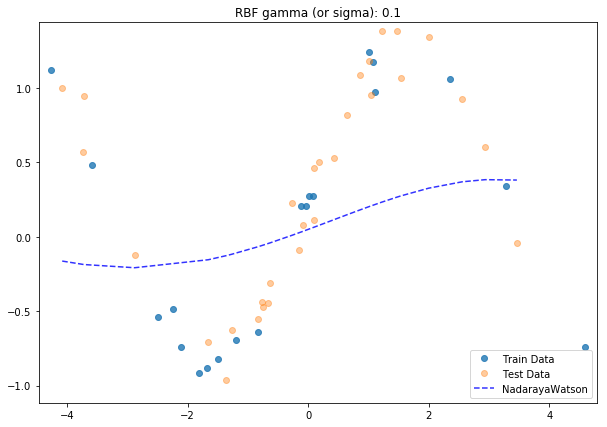

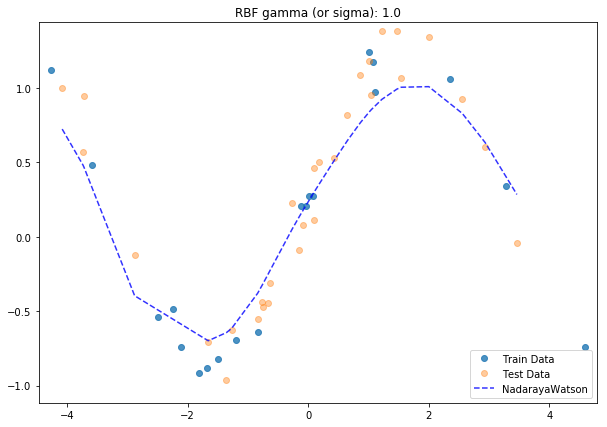

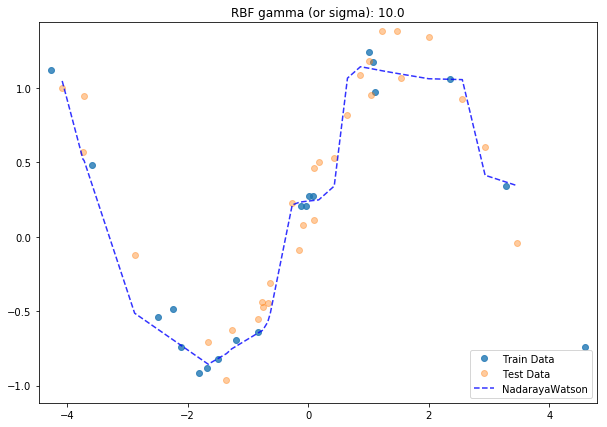

In [76]:
## 4. Train and predict using Nadaraya Watson Kernel Regression
for gamma in [0.1, 1, 10]:
    # 1. Fit model
    model = Fit_NadarayaWatson(Xtrain, ytrain, kernel="rbf", gamma=gamma)
    yhat = Predict_NadarayaWatson(model, Xtest)

    ## 2. Plot results
    plt.plot(Xtrain, ytrain, 'o', alpha=0.8, label="Train Data")
    plt.plot(Xtest, ytest, 'o', alpha=0.4, label="Test Data")
    plt.plot(Xtest, yhat, "b--", alpha=0.8, label="NadarayaWatson")
    plt.title("RBF gamma (or sigma): %.1f" % gamma)
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.legend(loc="lower right")
    plt.show()


We compare how the gamma (or sigma) values affect the Nadaraya-Watson model:

Finally let's compare between the three models:
    1. Linear Regression
    2. Locally Weighted Regression
    3. Nadaraya-Watson Kernel Regression

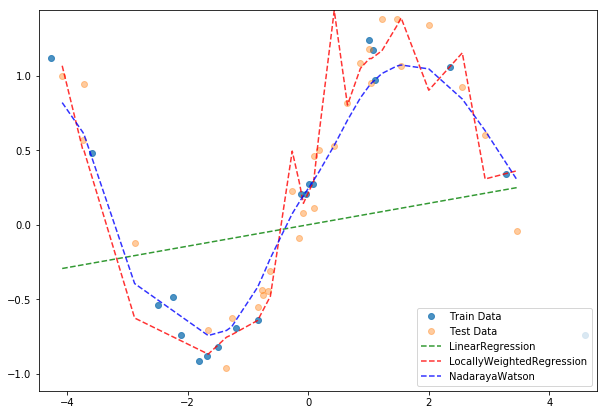

In [77]:
## 1. Train and predict using Linear Regression
model = Fit_LinearRegression(Xtrain, ytrain)
yhat_lr = Predict_LinearRegression(model, Xtest)

## 2. Train and predict using Locally Weighted Regression
model = Fit_LocallyWeightedRegression(Xtrain, ytrain, gamma=100)
yhat_lwr = Predict_LocallyWeightedRegression(model, Xtest)

## 3. Train and predict using Nadaraya Watson Kernel Regression
model = Fit_NadarayaWatson(Xtrain, ytrain, kernel="rbf", gamma=1.5)
yhat_nw = Predict_NadarayaWatson(model, Xtest)

## 4. Plot results
plt.plot(Xtrain, ytrain, 'o', alpha=0.8, label="Train Data")
plt.plot(Xtest, ytest, 'o', alpha=0.4, label="Test Data")
plt.plot(Xtest, yhat_lr, "g--", alpha=0.8, label="LinearRegression")
plt.plot(Xtest, yhat_lwr,"r--", alpha=0.8, label="LocallyWeightedRegression")
plt.plot(Xtest, yhat_nw, "b--", alpha=0.8, label="NadarayaWatson")

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.legend(loc="lower right")